# Telecom Churn Prediction - Survival Analysis

In [ ]:
!pip install lifelines

In [ ]:
# to access the data on google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from scipy import stats

import sklearn
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline

from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullAFTFitter

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("talk")

# supress unnecessary warning msgs
# import warnings
# warnings.filterwarnings('ignore')

# Telcom Churn Prediction

Which customers are likely to churn? What are the attributes that make you think so?

The features:
  - customerID - customer id
  - gender - client gender (male / female)
  - SeniorCitizen - is the client retired (1, 0)
  - Partner - is the client married (Yes, No)
  - Dependents - whether the customer has dependents or not (Yes, No)
  - tenure - how many months a person has been a client of the company
  - PhoneService - is the telephone service connected (Yes, No)
  - MultipleLines - are multiple phone lines connected (Yes, No, No phone service)
  - InternetService - client’s Internet service provider (DSL, Fiber optic, No)
  - OnlineSecurity - is the online security service connected (Yes, No, No internet service)
  - OnlineBackup - is the online backup service activated (Yes, No, No internet service)
  - DeviceProtection - does the client have equipment insurance (Yes, No, No internet service)
  - TechSupport - is the technical support service connected (Yes, No, No internet service)
  - StreamingTV - is the streaming TV service connected (Yes, No, No internet service)
  - StreamingMovies - is the streaming cinema service activated (Yes, No, No internet service)
  - Contract - type of customer contract (Month-to-month, One year, Two year)
  - PaperlessBilling - whether the client uses paperless billing (Yes, No)
  - PaymentMethod - payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
  - MonthlyCharges - current monthly payment
  - TotalCharges - the total amount that the client paid for the services for the entire time
  - Churn - whether there was a churn: customers who left within the last month (Yes or No)

In [ ]:
df_telco = pd.read_csv("/content/drive/MyDrive/propulsion/Machine_Learning/data/telecom_users.csv")
df = df_telco.drop(["Unnamed: 0", "customerID"], axis=1).copy()
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.2,No
2,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.5,No
4,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.5,No


In [ ]:
# replace TotalCharges that are blank with NaN
df["TotalCharges"] = df["TotalCharges"].replace(" ", np.nan)

# convert total charges to integer
df["TotalCharges"] = df["TotalCharges"].astype(float)

In [ ]:
# convert categorical variables to dummy variables
df_clean = df.replace({"No": 0, "No internet service": 0, "No phone service": 0, "Male": 0, "Yes": 1, "Female": 1, "DSL": 1, "Fiber optic": 1})
# group the payment type into automatic and other
df_clean["AutoPayment"] = np.where(df_clean["PaymentMethod"].str.contains("automatic"), 1, 0)
df_clean = df_clean.drop(columns=["PaymentMethod"])
# rename the variables
df_clean = df_clean.rename(columns={"gender": "Female", "Partner": "Married"})

In [ ]:
# create dummy variables from categorical variables
df_num = pd.get_dummies(df_clean)

# drop missing and standardize the MonthlyCharges variable to (0,1) range
df_num = df_num.dropna()
scaler = MinMaxScaler()
df_num[["MonthlyCharges_sc"]] = scaler.fit_transform(df_num[["MonthlyCharges"]])

In [ ]:
df_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5976 entries, 0 to 5985
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Female                   5976 non-null   int64  
 1   SeniorCitizen            5976 non-null   int64  
 2   Married                  5976 non-null   int64  
 3   Dependents               5976 non-null   int64  
 4   tenure                   5976 non-null   int64  
 5   PhoneService             5976 non-null   int64  
 6   MultipleLines            5976 non-null   int64  
 7   InternetService          5976 non-null   int64  
 8   OnlineSecurity           5976 non-null   int64  
 9   OnlineBackup             5976 non-null   int64  
 10  DeviceProtection         5976 non-null   int64  
 11  TechSupport              5976 non-null   int64  
 12  StreamingTV              5976 non-null   int64  
 13  StreamingMovies          5976 non-null   int64  
 14  PaperlessBilling        

In [ ]:
df_num

,Female,SeniorCitizen,Married,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,AutoPayment,Contract_Month-to-month,Contract_One year,Contract_Two year
0,0,0,1,1,72,1,1,0,0,0,...,0,0,0,0.058209,1734.65,0,1,0,0,1
1,1,0,0,0,44,1,0,1,0,1,...,1,0,1,0.695522,3973.20,0,1,1,0,0
2,1,1,1,0,38,1,1,1,0,0,...,0,0,1,0.564179,2869.85,1,1,1,0,0
3,0,0,0,0,4,1,0,1,0,0,...,0,1,1,0.374627,238.50,0,0,1,0,0
4,0,0,0,0,2,1,0,1,1,0,...,0,0,0,0.350249,119.50,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5981,0,0,1,0,1,1,0,1,1,0,...,1,1,1,0.763682,95.00,1,0,1,0,0
5982,1,0,1,1,23,1,1,1,1,1,...,1,1,1,0.724876,2198.30,0,1,0,0,1
5983,0,0,1,1,12,1,0,0,0,0,...,0,0,1,0.028856,306.05,0,0,1,0,0
5984,0,1,0,0,12,1,1,1,0,0,...,1,1,1,0.807960,1200.15,1,0,1,0,0


## Survival Analysis

In [ ]:
# create a Kaplan Meier object
kmf = KaplanMeierFitter()

# fit the values
kmf.fit(durations = df_num["tenure"], event_observed = df_num["Churn"])
kmf.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,5976,5976
1.0,510,318,192,0,5976
2.0,194,104,90,0,5466
3.0,169,82,87,0,5272
4.0,154,73,81,0,5103
...,...,...,...,...,...
68.0,89,8,81,0,716
69.0,77,6,71,0,627
70.0,90,10,80,0,550


In [ ]:
# Cox Hazard model with minmax scaled MonthlyCharges

df_cph = df_num.drop(columns=["Contract_Month-to-month", "InternetService", "TotalCharges", "MonthlyCharges"])

# create a Cox regression object
cph = CoxPHFitter()

# fit the values
cph.fit(df_cph, "tenure", event_col = "Churn")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5976 total observations, 4389 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 5976
number of events observed = 1587
   partial log-likelihood = -11551.65
         time fit was run = 2022-09-30 13:38:06 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
Female              0.09       1.09       0.05            -0.01             0.19                 0.99                 1.21
SeniorCitizen      -0.08       0.93       0.06            -0.20             0.04                 0.82                 1.05
Married            -0.48       0.62       0.06            -0.60            -0.36                 0.55                 0.70
Dependents         -0.04       0.96       0.07            -0.19             0.10                 0.83                 1.11
PhoneService       -0.57       0.57       0.12            -0.79            -0.34                 0.45                 0.71
MultipleLines      -0.60       0.55       0.06            -0.72            -0.48                 0.49                 0.62
OnlineSecurity     -0.74       0.48       0.07            -0.88            -0.60                 0.42                 0.55
OnlineBackup       -0.73       0.48       0.06            -0.84            -0.61                 0.43                 0.55
DeviceProtection   -0.41       0.67       0.06            -0.53            -0.29                 0.59                 0.75
TechSupport        -0.48       0.62       0.07            -0.62            -0.34                 0.54                 0.71
StreamingTV        -0.28       0.76       0.07            -0.40            -0.15                 0.67                 0.86
StreamingMovies    -0.36       0.69       0.07            -0.49            -0.24                 0.61                 0.79
PaperlessBilling    0.17       1.18       0.06             0.05             0.29                 1.05                 1.33
AutoPayment        -0.61       0.55       0.06            -0.72            -0.49                 0.49                 0.61
Contract_One year  -1.63       0.20       0.09            -1.81            -1.45                 0.16                 0.24
Contract_Two year  -3.33       0.04       0.18            -3.68            -2.99                 0.03                 0.05
MonthlyCharges_sc   2.42      11.27       0.21             2.02             2.83                 7.51                16.91

                    cmp to      z      p   -log2(p)
covariate                                          
Female                0.00   1.76   0.08       3.67
SeniorCitizen         0.00  -1.24   0.21       2.22
Married               0.00  -8.06 <0.005      50.25
Dependents            0.00  -0.60   0.55       0.87
PhoneService          0.00  -4.87 <0.005      19.77
MultipleLines         0.00  -9.88 <0.005      73.99
OnlineSecurity        0.00 -10.19 <0.005      78.53
OnlineBackup          0.00 -11.89 <0.005     105.94
DeviceProtection      0.00  -6.60 <0.005      34.53
TechSupport           0.00  -6.71 <0.005      35.60
StreamingTV           0.00  -4.17 <0.005      15.02
StreamingMovies       0.00  -5.54 <0.005      24.95
PaperlessBilling      0.00   2.76   0.01       7.43
AutoPayment           0.00 -10.31 <0.005      80.46
Contract_One year     0.00 -17.39 <0.005     222.58
Contract_Two year     0.00 -18.93 <0.005     263.10
MonthlyCharges_sc     0.00  11.71 <0.005     102.80
---
Concordance = 0.87
Partial AIC = 23137.30
log-likelihood ratio test = 2954.19 on 17 df
-log2(p) of ll-ratio test = inf

In [ ]:
# items to be removed
unwanted_elem = {"tenure", "Churn", "PaperlessBilling", "PhoneService", "DeviceProtection"}
 
col_plot = [ele for ele in df_cph.columns.tolist() if ele not in unwanted_elem]
col_plot

['Female',
 'SeniorCitizen',
 'Married',
 'Dependents',
 'MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'AutoPayment',
 'Contract_One year',
 'Contract_Two year',
 'MonthlyCharges_sc']

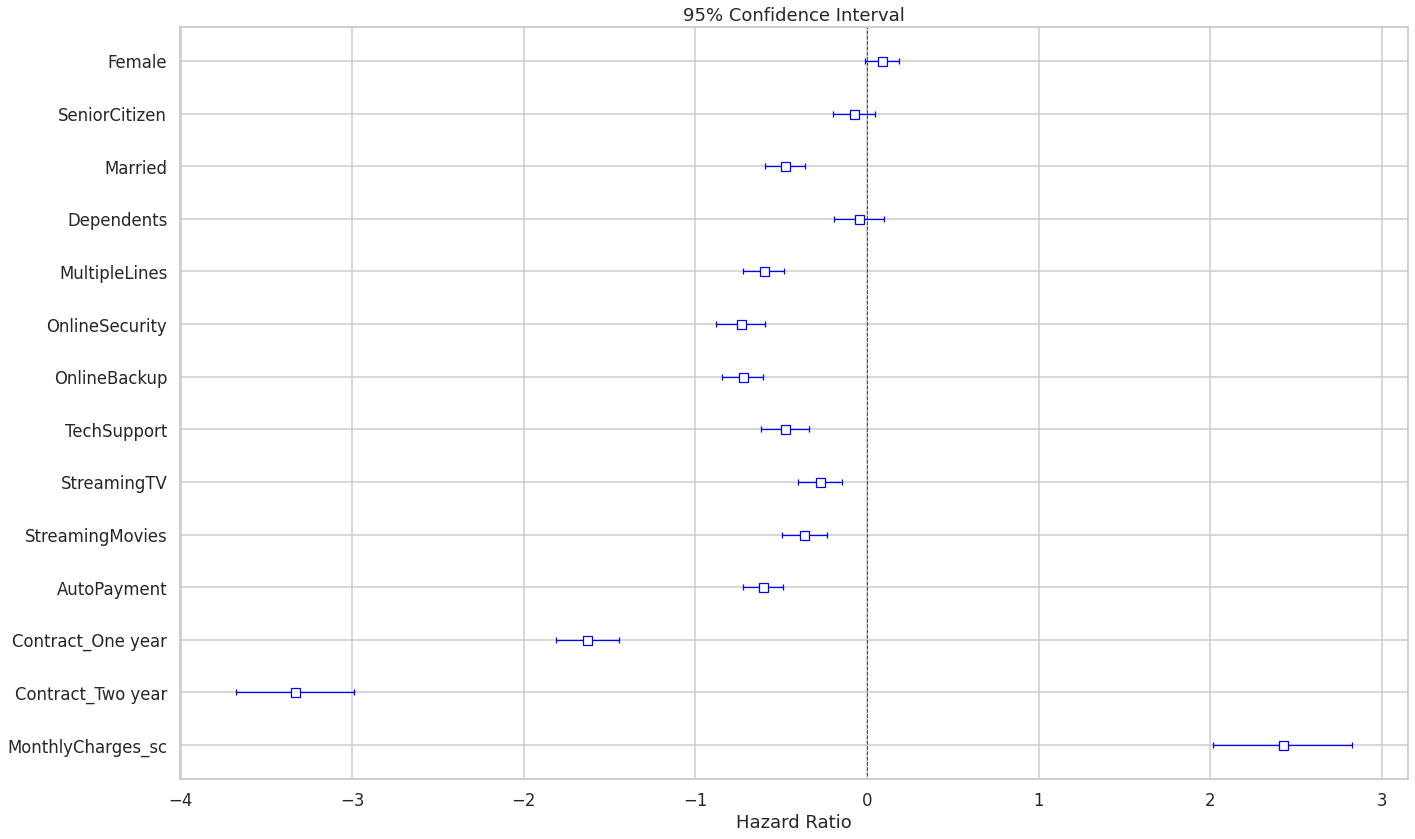

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
ax = cph.plot(col_plot, color="blue")
ax.set_title("95% Confidence Interval")
ax.set_xlabel("Hazard Ratio")
plt.tight_layout()
plt.show()


In [ ]:
# Weibull AFT model with minmax scaled MonthlyCharges
# The Cox Hazard model looks at survival rate, while this AFT model looks at survival time

df_cph = df_num.drop(columns=["Contract_Month-to-month", "InternetService", "TotalCharges", "MonthlyCharges"])

# create a Weibull regression object

aft = WeibullAFTFitter()
aft.fit(df_cph, duration_col="tenure", event_col="Churn")

aft.print_summary(3)  # access the results with 3 decimal points


<lifelines.WeibullAFTFitter: fitted with 5976 total observations, 4389 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
   number of observations = 5976
number of events observed = 1587
           log-likelihood = -7613.395
         time fit was run = 2022-09-30 15:09:19 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                 
lambda_ AutoPayment        0.654      1.923      0.064            0.529            0.778                1.698                2.177
        Contract_One year  1.598      4.944      0.102            1.398            1.798                4.048                6.039
        Contract_Two year  2.978     19.639      0.187            2.612            3.343               13.623               28.311
        Dependents         0.097      1.102      0.081           -0.061            0.255                0.941                1.291
        DeviceProtection   0.416      1.516      0.066            0.286            0.546                1.331                1.726
        Female            -0.080      0.923      0.055           -0.187            0.027                0.829                1.027
        Married            0.471      1.601      0.063            0.347            0.595                1.415                1.813
        MonthlyCharges_sc -2.573      0.076      0.232           -3.027           -2.119                0.048                0.120
        MultipleLines      0.640      1.896      0.065            0.512            0.767                1.669                2.153
        OnlineBackup       0.711      2.036      0.065            0.583            0.839                1.792                2.314
        OnlineSecurity     0.783      2.188      0.079            0.628            0.938                1.874                2.555
        PaperlessBilling  -0.195      0.823      0.066           -0.325           -0.064                0.722                0.938
        PhoneService       0.605      1.832      0.127            0.356            0.855                1.427                2.350
        SeniorCitizen      0.075      1.078      0.067           -0.056            0.205                0.946                1.228
        StreamingMovies    0.380      1.462      0.071            0.240            0.519                1.272                1.680
        StreamingTV        0.289      1.336      0.071            0.150            0.429                1.161                1.536
        TechSupport        0.535      1.707      0.077            0.383            0.686                1.467                1.986
        Intercept          3.198     24.491      0.113            2.977            3.420               19.623               30.567
rho_    Intercept         -0.082      0.921      0.021           -0.122           -0.042                0.885                0.959

                            cmp to       z       p   -log2(p)
param   covariate                                            
lambda_ AutoPayment          0.000  10.292 <0.0005     80.106
        Contract_One year    0.000  15.664 <0.0005    181.296
        Contract_Two year    0.000  15.956 <0.0005    187.967
        Dependents           0.000   1.207   0.227      2.137
        DeviceProtection     0.000   6.271 <0.0005     31.379
        Female               0.000  -1.466   0.143      2.808
        Married              0.000   7.452 <0.0005     43.304
        MonthlyCharges_sc    0.000 -11.105 <0.0005     92.772
        MultipleLines        0.000   9.855 <0.0005     73.701
        OnlineBackup         0.000  10.906 <0.0005     89.579
        OnlineSecurity       0.000   9.903 <0.0005     74.388
        PaperlessBilling     0.000  -2.929   0.003      8.199
        PhoneService         0.000   4.757 <0.

In [ ]:
print(aft.median_survival_time_)
print(aft.mean_survival_time_)

6.521967376932336
10.090266026387427


In [ ]:
# Cox Hazard model with unscaled MonthlyCharges

df_cph = df_num.drop(columns=["Contract_Month-to-month", "InternetService", "TotalCharges", "MonthlyCharges_sc"])

# create a Cox regression object
cph = CoxPHFitter()

# fit the values
cph.fit(df_cph, "tenure", event_col = "Churn")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 5976 total observations, 4389 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 5976
number of events observed = 1587
   partial log-likelihood = -11551.65
         time fit was run = 2022-09-30 13:34:19 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
Female              0.09       1.09       0.05            -0.01             0.19                 0.99                 1.21
SeniorCitizen      -0.08       0.93       0.06            -0.20             0.04                 0.82                 1.05
Married            -0.48       0.62       0.06            -0.60            -0.36                 0.55                 0.70
Dependents         -0.04       0.96       0.07            -0.19             0.10                 0.83                 1.11
PhoneService       -0.57       0.57       0.12            -0.79            -0.34                 0.45                 0.71
MultipleLines      -0.60       0.55       0.06            -0.72            -0.48                 0.49                 0.62
OnlineSecurity     -0.74       0.48       0.07            -0.88            -0.60                 0.42                 0.55
OnlineBackup       -0.73       0.48       0.06            -0.84            -0.61                 0.43                 0.55
DeviceProtection   -0.41       0.67       0.06            -0.53            -0.29                 0.59                 0.75
TechSupport        -0.48       0.62       0.07            -0.62            -0.34                 0.54                 0.71
StreamingTV        -0.28       0.76       0.07            -0.40            -0.15                 0.67                 0.86
StreamingMovies    -0.36       0.69       0.07            -0.49            -0.24                 0.61                 0.79
PaperlessBilling    0.17       1.18       0.06             0.05             0.29                 1.05                 1.33
MonthlyCharges      0.02       1.02       0.00             0.02             0.03                 1.02                 1.03
AutoPayment        -0.61       0.55       0.06            -0.72            -0.49                 0.49                 0.61
Contract_One year  -1.63       0.20       0.09            -1.81            -1.45                 0.16                 0.24
Contract_Two year  -3.33       0.04       0.18            -3.68            -2.99                 0.03                 0.05

                    cmp to      z      p   -log2(p)
covariate                                          
Female                0.00   1.76   0.08       3.67
SeniorCitizen         0.00  -1.24   0.21       2.22
Married               0.00  -8.06 <0.005      50.25
Dependents            0.00  -0.60   0.55       0.87
PhoneService          0.00  -4.87 <0.005      19.77
MultipleLines         0.00  -9.88 <0.005      73.99
OnlineSecurity        0.00 -10.19 <0.005      78.53
OnlineBackup          0.00 -11.89 <0.005     105.94
DeviceProtection      0.00  -6.60 <0.005      34.53
TechSupport           0.00  -6.71 <0.005      35.60
StreamingTV           0.00  -4.17 <0.005      15.02
StreamingMovies       0.00  -5.54 <0.005      24.95
PaperlessBilling      0.00   2.76   0.01       7.43
MonthlyCharges        0.00  11.71 <0.005     102.80
AutoPayment           0.00 -10.31 <0.005      80.46
Contract_One year     0.00 -17.39 <0.005     222.58
Contract_Two year     0.00 -18.93 <0.005     263.10
---
Concordance = 0.87
Partial AIC = 23137.30
log-likelihood ratio test = 2954.19 on 17 df
-log2(p) of ll-ratio test = inf

# Interpretation of Cox Hazard model

Hazard Ratio (HR) = exp(coefficient)

The p-value for AutoPayment is < 0.005 and Hazard Ratio (HR) is 0.55 indicating a strong relationship between the use of AutoPayment and decreased risk of churning. For example, holding the other covariates constant, using AutoPayment reduces the hazard of churning by a factor of 0.55, or 45%. 

# Conclusions

  - An increase in $1 of monthly charges increases churning by 2%.
  - Contract is the most effective way in reducing churning: one-year contract by 80% and two-year contract by 96%.
  - Convenience such as automatic payment reduces churning by 45%.
  - Customers with multiple phone lines are less likely to churn by 45%.
  - Married customers are less likely to churn by a ratio of 0.62 (38%).
  - In terms of services provided, all the following help to reduce churning but at various degrees. Most important are online security and backup features which reduce churning by 52%, while entertainment features such as streaming TV and movies reduce churning by around 30%. 